In [1]:
!pip install jsonlines
import os
import json
import jsonlines
import numpy as np
from tqdm import tqdm
from collections import defaultdict

In [0]:
import torch
import torch.nn as nn

In [2]:
def load_wikitext(filename='wikitext2-sentencized.json'):
    if not os.path.exists(filename):
        !wget "https://nyu.box.com/shared/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json" -O $filename
    
    datasets = json.load(open(filename, 'r'))
    for name in datasets:
        datasets[name] = [x.split() for x in datasets[name]]
    vocab = list(set([t for ts in datasets['train'] for t in ts]))      
    print("Vocab size: %d" % (len(vocab)))
    return datasets, vocab

datasets,vocab = load_wikitext()

--2019-09-30 02:34:24--  https://nyu.box.com/shared/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json
Resolving nyu.box.com (nyu.box.com)... 107.152.26.197, 107.152.27.197
Connecting to nyu.box.com (nyu.box.com)|107.152.26.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json [following]
--2019-09-30 02:34:24--  https://nyu.box.com/public/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json
Reusing existing connection to nyu.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://nyu.app.box.com/public/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json [following]
--2019-09-30 02:34:25--  https://nyu.app.box.com/public/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json
Resolving nyu.app.box.com (nyu.app.box.com)... 107.152.26.199, 107.152.27.199
Connecting to nyu.app.box.com (nyu.app.box.com)|107.152.26.199|:443... connected.
HTTP request sent, awaiting response... 302 Found
Locati

In [0]:
class Dictionary(object):
    def __init__(self, datasets, include_valid=False):
        self.tokens = []
        self.ids = {}
        self.counts = {}
        
        # add special tokens
        self.add_token('<bos>')
        self.add_token('<eos>')
        self.add_token('<pad>')
        self.add_token('<unk>')
        
        for line in tqdm(datasets['train']):
            for w in line:
                self.add_token(w)
                    
        if include_valid is True:
            for line in tqdm(datasets['valid']):
                for w in line:
                    self.add_token(w)
        # include test
        for line in tqdm(datasets['test']):
            for w in line:
                self.add_token(w)
        
        
    def add_token(self, w):
        if w not in self.tokens:
            self.tokens.append(w)
            _w_id = len(self.tokens) - 1
            self.ids[w] = _w_id
            self.counts[w] = 1
        else:
            self.counts[w] += 1

    def get_id(self, w):
        return self.ids[w]
    
    def get_token(self, idx):
        return self.tokens[idx]
    
    def decode_idx_seq(self, l):
        return [self.tokens[i] for i in l]
    
    def encode_token_seq(self, l):
        return [self.ids[i] if i in self.ids else self.ids['<unk>'] for i in l]
    
    def __len__(self):
        return len(self.tokens)

In [0]:
def tokenize_dataset(datasets, dictionary, ngram_order=2):
    tokenized_datasets = {}
    for split, dataset in datasets.items():
        _current_dictified = []
        for l in tqdm(dataset):
            l = ['<bos>']*(ngram_order-1) + l + ['<eos>']
            encoded_l = dictionary.encode_token_seq(l)
            _current_dictified.append(encoded_l)
        tokenized_datasets[split] = _current_dictified
        
    return tokenized_datasets

In [5]:
wikitext_dict = Dictionary(datasets, include_valid=True)
# checking some example
print(' '.join(datasets['train'][3010]))

encoded = wikitext_dict.encode_token_seq(datasets['train'][3010])
print(f'\n encoded - {encoded}')
decoded = wikitext_dict.decode_idx_seq(encoded)
print(f'\n decoded - {decoded}')

100%|██████████| 9708/9708 [00:13<00:00, 709.03it/s]

The Nataraja and Ardhanarishvara sculptures are also attributed to the Rashtrakutas .

 encoded - [75, 8816, 30, 8817, 8732, 70, 91, 2960, 13, 6, 8806, 39]

 decoded - ['The', 'Nataraja', 'and', 'Ardhanarishvara', 'sculptures', 'are', 'also', 'attributed', 'to', 'the', 'Rashtrakutas', '.']


In [0]:
class RNNLanguageModel(nn.Module):
    """
    This model combines embedding, rnn and projection layer into a single model
    """
    def __init__(self, options):
        super().__init__()
        
        # create each LM part here 
        self.lookup = nn.Embedding(num_embeddings=options['num_embeddings'], embedding_dim=options['embedding_dim'], padding_idx=options['padding_idx'])
        self.rnn = nn.RNN(options['input_size'], options['hidden_size'], options['num_layers'], dropout=options['rnn_dropout'], batch_first=True)
        self.projection = nn.Linear(options['hidden_size'], options['num_embeddings'])
        
    def forward(self, encoded_input_sequence):
        """
        Forward method process the input from token ids to logits
        """
        # |V| -> emb_dim
        embeddings = self.lookup(encoded_input_sequence)
        # emb_dim, hidden -> (hidden,hidden*num_layers)
        rnn_outputs = self.rnn(embeddings)
        logits = self.projection(rnn_outputs[0])
        
        return logits

In [0]:
num_gpus = torch.cuda.device_count()
if num_gpus > 0:
    current_device = 'cuda'
else:
    current_device = 'cpu'

In [13]:
model_dict_RNN = torch.load('RNN_model.pt')    
options_RNN = model_dict_RNN['options']
model_RNN = RNNLanguageModel(options_RNN).to(current_device)
model_RNN.load_state_dict(torch.load("RNN_checkpoint.pt"))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [14]:
model_RNN

RNNLanguageModel(
  (lookup): Embedding(33186, 256, padding_idx=2)
  (rnn): RNN(256, 512, num_layers=3, batch_first=True, dropout=0.3)
  (projection): Linear(in_features=512, out_features=33186, bias=True)
)

In [0]:
class LSTMLanguageModel(nn.Module):
    """
    This model combines embedding, rnn and projection layer into a single model
    """
    def __init__(self, options):
        super().__init__()
        
        # create each LM part here 
        self.lookup = nn.Embedding(num_embeddings=options['num_embeddings'], embedding_dim=options['embedding_dim'], padding_idx=options['padding_idx'])
        self.lstm = nn.LSTM(options['input_size'], options['hidden_size'], options['num_layers'], dropout=options['lstm_dropout'], batch_first=True)
        self.projection = nn.Linear(options['hidden_size'], options['num_embeddings'])
        
    def forward(self, encoded_input_sequence):
        """
        Forward method process the input from token ids to logits
        """
        # |V| -> emb_dim
        embeddings = self.lookup(encoded_input_sequence)
        # emb_dim, hidden -> output, (h_n,c_n)     (hidden,hidden*num_layers)
        lstm_outputs = self.lstm(embeddings)
        logits = self.projection(lstm_outputs[0])
        
        return logits

In [18]:
model_dict_LSTM1 = torch.load('LSTM_model.pt')    
options_LSTM1 = model_dict_LSTM1['options']
model_LSTM1 = LSTMLanguageModel(options_LSTM1).to(current_device)
model_LSTM1.load_state_dict(torch.load("LSTM_checkpoint.pt"))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [19]:
model_LSTM1

LSTMLanguageModel(
  (lookup): Embedding(33186, 256, padding_idx=2)
  (lstm): LSTM(256, 512, num_layers=3, batch_first=True, dropout=0.3)
  (projection): Linear(in_features=512, out_features=33186, bias=True)
)

In [20]:
model_dict_LSTM2 = torch.load('LSTM_bigger_model.pt')    
options_LSTM2 = model_dict_LSTM2['options']
model_LSTM2 = LSTMLanguageModel(options_LSTM2).to(current_device)
model_LSTM2.load_state_dict(torch.load("LSTM_bigger_checkpoint.pt"))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [22]:
model_LSTM2

LSTMLanguageModel(
  (lookup): Embedding(33186, 512, padding_idx=2)
  (lstm): LSTM(512, 1024, num_layers=3, batch_first=True, dropout=0.3)
  (projection): Linear(in_features=1024, out_features=33186, bias=True)
)

# 2.1: LSTM vs. RNN

In [0]:
import matplotlib.pyplot as plt
import numpy as np

plot_cache_RNN = model_dict_RNN['loss_cache']
plot_cache_LSTM1 = model_dict_LSTM1['loss_cache']
plot_cache_LSTM2 = model_dict_LSTM2['loss_cache']

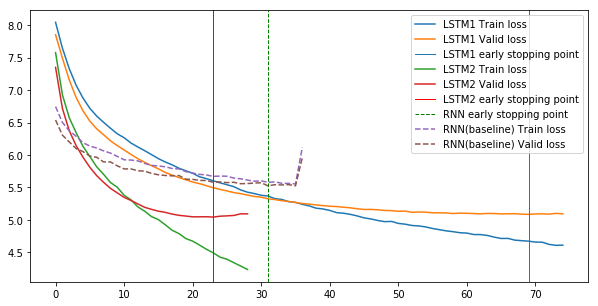

In [29]:
epochs_RNN = np.array(list(range(len(plot_cache_RNN))))
epochs_LSTM1 = np.array(list(range(len(plot_cache_LSTM1))))
epochs_LSTM2 = np.array(list(range(len(plot_cache_LSTM2))))
plt.figure(figsize=(10,5))


plt.plot(epochs_LSTM1, [i[0] for i in plot_cache_LSTM1], label='LSTM1 Train loss')
plt.plot(epochs_LSTM1, [i[1] for i in plot_cache_LSTM1], label='LSTM1 Valid loss')
plt.axvline(x=epochs_LSTM1[-6],label="LSTM1 early stopping point",linewidth=1)


plt.plot(epochs_LSTM2, [i[0] for i in plot_cache_LSTM2], label='LSTM2 Train loss')
plt.plot(epochs_LSTM2, [i[1] for i in plot_cache_LSTM2], label='LSTM2 Valid loss')
plt.axvline(x=epochs_LSTM2[-6],label="LSTM2 early stopping point",linewidth=1,color="r")


plt.axvline(x=epochs_RNN[-6],label="RNN early stopping point",color="g",linestyle="--",linewidth=1)
plt.plot(epochs_RNN, [i[0] for i in plot_cache_RNN], label='RNN(baseline) Train loss',linestyle="--")
plt.plot(epochs_RNN, [i[1] for i in plot_cache_RNN], label='RNN(baseline) Valid loss',linestyle="--")


plt.legend()
plt.show()

In [34]:
print("Perplexity for RNN baseline is",[2**(i[1]/np.log(2)) for i in plot_cache_RNN][-6])
print("Perplexity for LSTM1 is",[2**(i[1]/np.log(2)) for i in plot_cache_LSTM1][-6])
print("Perplexity for LSTM2 is",[2**(i[1]/np.log(2)) for i in plot_cache_LSTM2][-6])

Perplexity for RNN baseline is 250.64625058797918
Perplexity for LSTM1 is 161.6276941957559
Perplexity for LSTM2 is 154.94733051084611


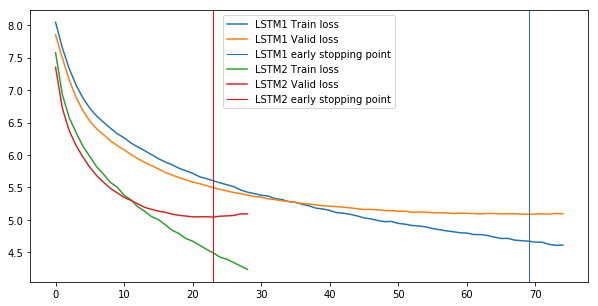

In [32]:
epochs_LSTM1 = np.array(list(range(len(plot_cache_LSTM1))))
epochs_LSTM2 = np.array(list(range(len(plot_cache_LSTM2))))
plt.figure(figsize=(10,5))


plt.plot(epochs_LSTM1, [i[0] for i in plot_cache_LSTM1], label='LSTM1 Train loss')
plt.plot(epochs_LSTM1, [i[1] for i in plot_cache_LSTM1], label='LSTM1 Valid loss')
plt.axvline(x=epochs_LSTM1[-6],label="LSTM1 early stopping point",linewidth=1)


plt.plot(epochs_LSTM2, [i[0] for i in plot_cache_LSTM2], label='LSTM2 Train loss')
plt.plot(epochs_LSTM2, [i[1] for i in plot_cache_LSTM2], label='LSTM2 Valid loss')
plt.axvline(x=epochs_LSTM2[-6],label="LSTM2 early stopping point",linewidth=1,color="r")
plt.legend()
plt.show()

# 2.2: Learned embeddings

## Lookup

In [36]:
!pip install umap-learn

In [38]:
weight_matrix_lookup = model_LSTM2.lookup.weight

word_list = ["Japan","man","speak","basketball","happy"]
word_list_id = [wikitext_dict.get_id(word) for word in word_list]
word_list_id

[18, 3540, 7693, 9981, 4233]

In [46]:
def cosine_similarity(x1, x2, dim=0, eps=1e-8):
    w12 = torch.sum(x1 * x2, dim)
    w1 = torch.norm(x1, 2, dim)
    w2 = torch.norm(x2, 2, dim)
    return (w12 / (w1 * w2).clamp(min=eps)).squeeze()

cosine_similarity(torch.rand(3,1),torch.rand(3,1))

tensor(0.8555)

In [0]:
closest_dict_lookup = {}
farthest_dict_lookup = {}

lsts_lookup = {}

for word in word_list:
    lst_lookup = []
    word_id = wikitext_dict.get_id(word)
    for i in range(weight_matrix_lookup.size(0)):
        if i not in [2,word_id]:
            cos_sim = cosine_similarity(weight_matrix_lookup[word_id],weight_matrix_lookup[i])
            lst_lookup.append((cos_sim.item(),i))
        lst_lookup = sorted(lst_lookup, key=lambda x: x[0], reverse=True)
        lsts_lookup[word] = lst_lookup
        closest_dict_lookup[word] = [l[1] for l in lst_lookup[:10]]
        farthest_dict_lookup[word] = [l[1] for l in lst_lookup[-10:]]

In [59]:
for word in word_list:
  print("the closest 10 for", word, ":", [wikitext_dict.get_token(i) for i in closest_dict_lookup[word]])
  print("the farthest 10 for", word, ":",[wikitext_dict.get_token(i) for i in farthest_dict_lookup[word]])
  print("highest cosine similarity:", lsts_lookup[word][0][0], "word:", wikitext_dict.get_token(lsts_lookup[word][0][1]))
  print("lowest cosine similarity:", lsts_lookup[word][-1][0], "word:", wikitext_dict.get_token(lsts_lookup[word][-1][1]))
  print("\n\n")

the closest 10 for Japan : ['megaliths', 'publishers', 'respite', 'overlaps', 'prejudices', 'Beyond', 'Chutzpah', 'Stephen', 'transatlantic', 'WCW']
the farthest 10 for Japan : ['Poesy', '0000', 'Slide', 'Xavier', 'ini', 'illness', 'Hardy', 'Ravel', 'joins', 'MonarC']
highest cosine similarity: 0.1666162610054016 word: megaliths
lowest cosine similarity: -0.17725931107997894 word: MonarC



the closest 10 for man : ['attack', 'Facebook', 'aisles', 'brightest', 'deposit', 'Hanson', 'unenviable', 'Species', 'criticised', 'Uchiyama']
the farthest 10 for man : ['choreographed', 'ornithischians', 'unionist', 'honours', 'concerns', 'townships', 'Bhakti', 'starred', 'publishes', 'lessons']
highest cosine similarity: 0.1609833836555481 word: attack
lowest cosine similarity: -0.1721363365650177 word: lessons



the closest 10 for speak : ['implicit', 'iodine', 'cm', 'covert', 'reveal', 'arise', 'crossed', 'landings', 'pounding', 'erratic']
the farthest 10 for speak : ['183', 'routine', 'Season'

In [69]:
%pylab inline 
import umap

def umap_plot(weight_matrix, word_ids, words):
    """Run UMAP on the entire Vxd `weight_matrix` (e.g. model.lookup.weight or model.projection.weight),
    And plot the points corresponding to the given `word_ids`. """
    reduced = umap.UMAP(min_dist=0.0001).fit_transform(weight_matrix.detach().cpu().numpy())
    plt.figure(figsize=(15,15))

    to_plot = reduced[word_ids, :]
    plt.scatter(to_plot[:, 0], to_plot[:, 1])
    for i, word_id in enumerate(word_ids):
        current_point = to_plot[i]
        plt.annotate(words[i], (current_point[0], current_point[1]))

    plt.grid()
    plt.show()

Populating the interactive namespace from numpy and matplotlib


In [0]:
total_idx_lookup = [closest_dict_lookup[w] for w in word_list] + [farthest_dict_lookup[w] for w in word_list]
import itertools
total_idx_lookup = list(itertools.chain(*total_idx_lookup))
total_words_lookup = word_list + [wikitext_dict.get_token(i) for i in total_idx_lookup]
total_idx_lookup = [wikitext_dict.get_id(w) for w in word_list] + total_idx_lookup

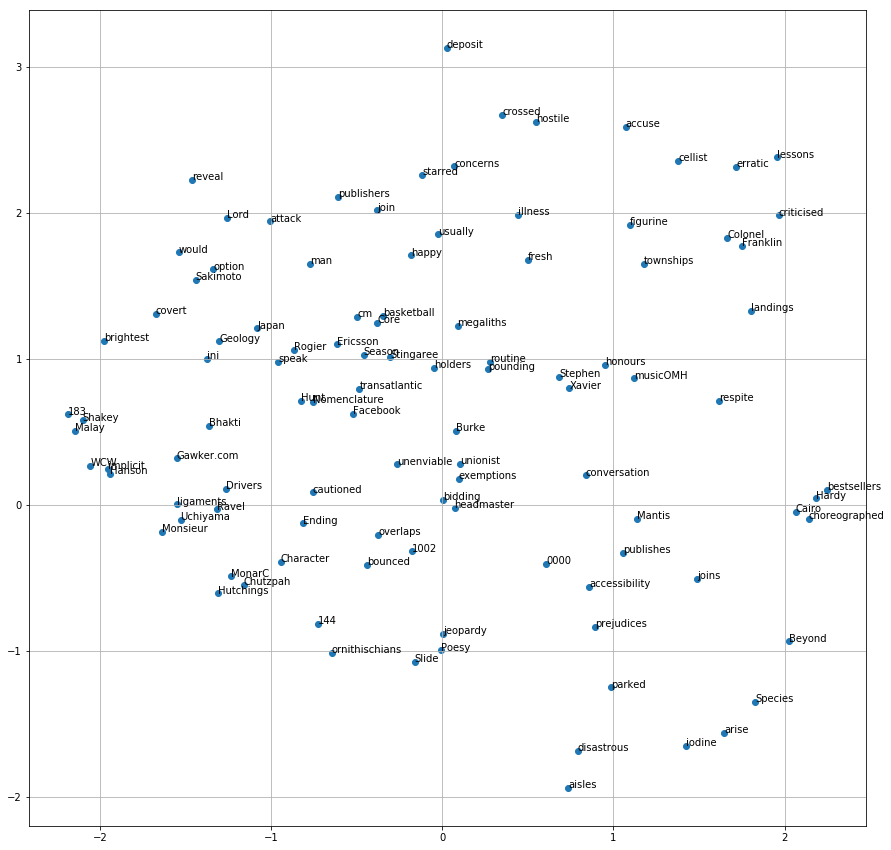

In [71]:
umap_plot(weight_matrix_lookup, total_idx_lookup, total_words_lookup)

## Projection

In [0]:
weight_matrix_projection = model_LSTM2.projection.weight

In [0]:
closest_dict_projection = {}
farthest_dict_projection = {}

lsts_projection = {}

for word in word_list:
    lst_projection = []
    word_id = wikitext_dict.get_id(word)
    for i in range(weight_matrix_projection.size(0)):
        if i not in [2,word_id]:
            cos_sim = cosine_similarity(weight_matrix_projection[word_id],weight_matrix_projection[i])
            lst_projection.append((cos_sim.item(),i))
        lst_projection = sorted(lst_projection, key=lambda x: x[0], reverse=True)
        lsts_projection[word] = lst_projection
        closest_dict_projection[word] = [l[1] for l in lst_projection[:10]]
        farthest_dict_projection[word] = [l[1] for l in lst_projection[-10:]]

In [67]:
for word in word_list:
  print("the closest 10 for", word, ":", [wikitext_dict.get_token(i) for i in closest_dict_projection[word]])
  print("the farthest 10 for", word, ":",[wikitext_dict.get_token(i) for i in farthest_dict_projection[word]])
  print("highest cosine similarity:", lsts_projection[word][0][0], "word:", wikitext_dict.get_token(lsts_projection[word][0][1]))
  print("lowest cosine similarity:", lsts_projection[word][-1][0], "word:", wikitext_dict.get_token(lsts_projection[word][-1][1]))
  print("\n\n")

the closest 10 for Japan : ['Canada', 'Europe', 'Germany', 'Australia', 'Switzerland', 'France', 'North', 'Belgium', 'Italy', 'India']
the farthest 10 for Japan : ['ferocious', 'coerced', 'worried', 'revered', 'formidable', 'forgotten', 'invoked', 'docile', 'necklace', 'persuasive']
highest cosine similarity: 0.5814674496650696 word: Canada
lowest cosine similarity: -0.2716080844402313 word: persuasive



the closest 10 for man : ['woman', 'person', 'female', 'story', 'male', 'child', 'young', 'human', 'group', 'people']
the farthest 10 for man : ['Scotus', 'Waller', 'Hague', 'Kabir', 'Hamersley', 'Shinde', 'Diarmata', '372', 'Critique', '<bos>']
highest cosine similarity: 0.6058748960494995 word: woman
lowest cosine similarity: -0.26336777210235596 word: <bos>



the closest 10 for speak : ['accept', 'tell', 'understand', 'consider', 'know', 'learn', 'hear', 'believe', 'suggest', 'keep']
the farthest 10 for speak : ['Community', 'Vessel', 'Emmy', 'Huron', 'Lauderdale', 'Champlain', 'F

In [0]:
total_idx_projection = [closest_dict_projection[w] for w in word_list] + [farthest_dict_projection[w] for w in word_list]
import itertools
total_idx_projection = list(itertools.chain(*total_idx_projection))
total_words_projection = word_list + [wikitext_dict.get_token(i) for i in total_idx_projection]
total_idx_projection = [wikitext_dict.get_id(w) for w in word_list] + total_idx_projection

/usr/local/lib/python3.6/dist-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


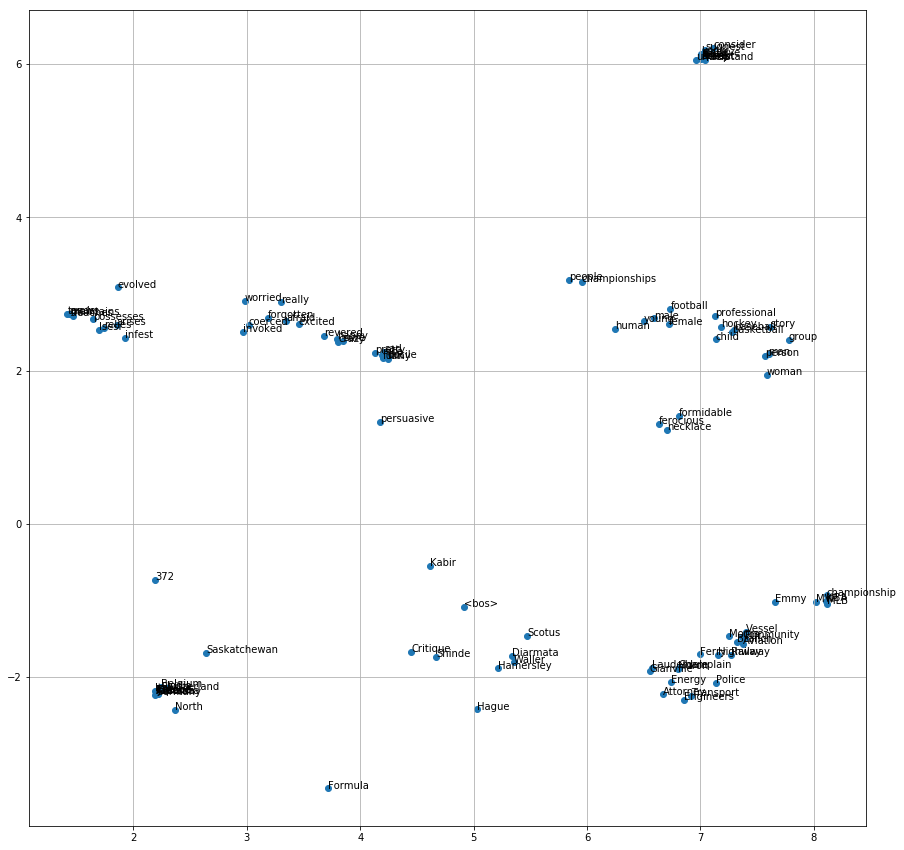

In [73]:
umap_plot(weight_matrix_projection, total_idx_projection, total_words_projection)

## Scoring

In [77]:
def get_prob_of_sequence(seq, token = "<eos>"):
    inp = wikitext_dict.encode_token_seq(seq.split(' '))
    target = inp[1:] + [wikitext_dict.get_id(token)]
    
    with torch.no_grad():
        model_LSTM2.eval()
        logits = model_LSTM2(torch.tensor([inp], dtype=torch.long).to(current_device))
    #print(logits.shape) 
    T = len(inp)
    ans = 0
    for i in range(T):
        tokid = target[i]
        prob_distr = torch.softmax(logits[0,i], dim=-1)
        prob_distr = prob_distr.cpu()
        ans += np.log(prob_distr[tokid]).item()
    return ans

seq = "<bos> i have cat"
get_prob_of_sequence(seq)

-42.32510757446289

In [0]:
import torch
from torch.utils.data import Dataset, RandomSampler, SequentialSampler, DataLoader

class TensoredDataset(Dataset):
    def __init__(self, list_of_lists_of_tokens):
        self.input_tensors = []
        self.target_tensors = []
        
        for sample in list_of_lists_of_tokens:
            self.input_tensors.append(torch.tensor([sample[:-1]], dtype=torch.long))
            self.target_tensors.append(torch.tensor([sample[1:]], dtype=torch.long))
    
    def __len__(self):
        return len(self.input_tensors)
    
    def __getitem__(self, idx):
        # return a (input, target) tuple
        return (self.input_tensors[idx], self.target_tensors[idx])

In [80]:
wikitext_tokenized_datasets = tokenize_dataset(datasets, wikitext_dict)
wikitext_tensor_dataset = {}

for split, listoflists in wikitext_tokenized_datasets.items():
    wikitext_tensor_dataset[split] = TensoredDataset(listoflists)

100%|██████████| 9708/9708 [00:00<00:00, 30274.73it/s]


In [0]:
lst = []
for i,(k,v) in enumerate(wikitext_tensor_dataset["valid"]):
    seq = [wikitext_dict.get_token(int(j)) for w in wikitext_tensor_dataset["valid"][i][0] for j in w]
    seq = " ".join(seq)
    lst.append(get_prob_of_sequence(seq))
    
lst = [i for i in sorted(enumerate(lst), key=lambda x:x[1])]

In [84]:
lowest_idx = [l[0] for l in lst[:10]]
lowest_scores = [l[1] for l in lst[:10]]
highest_idx = [l[0] for l in lst[-100:]]
highest_scores = [l[1] for l in lst[-100:]]

for i in range(len(highest_idx)):
    idx = highest_idx[i]
    score = highest_scores[i]
    seq = [wikitext_dict.get_token(int(j)) for w in wikitext_tensor_dataset["valid"][idx][0] for j in w]
    seq += ["eos"]
    print("Score:",score,":", " ".join(seq))

Score: -40.02651512622833 : <bos> The video was also certified gold in Brazil by the <unk> <unk> eos
Score: -39.9744548201561 : <bos> Other notable natives of the city include : eos
Score: -39.95684996433556 : <bos> The <unk> referred to the invaders as the <unk> ( eos
Score: -39.91608887491748 : <bos> The song reached number four on the UK Singles Chart , and it topped the Irish Singles Chart . eos
Score: -39.65248414513189 : <bos> There is a stone bellcote at the west end . eos
Score: -39.62647887431376 : <bos> He was selected as chairman of the department in June 2002 . eos
Score: -39.616554740816355 : <bos> The song , however , reached the top of the Hot Dance Club eos
Score: -39.58636747743003 : <bos> At this time , <unk> participated in the widespread <unk eos
Score: -39.45690498268232 : <bos> unk> Christie took place on 12 January 2005 . eos
Score: -39.43865175935207 : <bos> > 's performance was nominated for a Drama <unk> Award . eos
Score: -39.42986906925216 : <bos> The Daily 

In [85]:
for i in range(len(lowest_idx)):
    idx = lowest_idx[i]
    score = lowest_scores[i]
    seq = [wikitext_dict.get_token(int(j)) for w in wikitext_tensor_dataset["valid"][idx][0] for j in w]
    seq += ["eos"]
    print("Score:",score,":", " ".join(seq))

Score: -545.1292685726658 : <bos> To further justify its stance , the German government has also pointed to the long history of U.S. court cases involving Scientology , including the conviction of 11 top Scientologists in 1979 and 1980 for a conspiracy involving the infiltration of U.S. government agencies , <unk> and the theft of government documents , a 1994 U.S. Supreme Court finding that Scientology practices took place in a " <unk> environment " , and Scientology 's track record of pursuing its critics through malicious court cases and private investigators . eos
Score: -520.6697776723886 : <bos> Two rival communist @-@ backed black nationalist groups initiated military campaigns to overthrow the government and introduce majority rule : the Chinese @-@ aligned Zimbabwe African National Union ( <unk> ) , mostly comprising <unk> , created the Zimbabwe African National Liberation Army ( ZANLA ) and adopted aspects of <unk> doctrine , while the <unk> @-@ dominated Zimbabwe African Peo

In [162]:
idx = highest_idx[30]
score = highest_scores[30]
seq = [wikitext_dict.get_token(int(j)) for w in wikitext_tensor_dataset["valid"][idx][0] for j in w]
seq += ["<eos>"]
print("Score:",score,":", " ".join(seq))

new_seq = ['<bos>','The', 'area', 'is', 'also', 'famous', 'for', 'its', 'basketball', 'culture', '.']
new_score = get_prob_of_sequence(" ".join(new_seq))
print("Score:",new_score,":", " ".join(new_seq)," '<eos>'")

new_seq = ['<bos>','The', 'city', 'is', 'also', 'home', 'to', 'the', 'German', 'government', '.']
new_score = get_prob_of_sequence(" ".join(new_seq))
print("Score:",new_score,":", " ".join(new_seq)," '<eos>'")

Score: -38.18879095651209 : <bos> The city is also home to four industrial parks . <eos>
Score: -47.28297503851354 : <bos> The area is also famous for its basketball culture .  '<eos>'
Score: -33.980702829081565 : <bos> The city is also home to the German government .  '<eos>'


## Sampling

In [175]:
samples = []
for i in range(1000):
    start_index = torch.tensor([wikitext_dict.get_id("<bos>")])
    inp = start_index
    sample = ["<bos>"]
    model_LSTM2.eval()
    while inp.item() != wikitext_dict.get_id("<eos>"):
        out = model_LSTM2.lookup(inp.to(current_device))
        out.unsqueeze_(1)
        out = model_LSTM2.lstm(out)
        out = out[0]
        out = model_LSTM2.projection(out).to(current_device)
        p = torch.softmax(out[0,-1], dim=-1)
        #sample_id = torch.argmax(p)
        sample_id = torch.multinomial(p,1).item()
        sample_token = wikitext_dict.get_token(sample_id)
        sample.append(sample_token)
        inp = torch.tensor([wikitext_dict.get_id(sample_token)])
    samples.append(" ".join(sample))

1000

In [0]:
import random
ids = random.sample(range(len(wikitext_tensor_dataset["valid"])), 1000)
samples_val = []
wikitext_tokenized_datasets["valid"][0]

for i in ids:
  sent = wikitext_tokenized_datasets["valid"][i]
  sent = [wikitext_dict.get_token(idx) for idx in sent]
  samples_val.append(" ".join(sent))

In [200]:
set_sample = set()
set_sample_val = set()
len_sample = []
len_sample_val = []

for i in range(len(samples)):
  sent = samples[i].split(" ")
  len_sample.append(len(sent))
  for word in sent:
    set_sample.add(word)
  
for i in range(len(samples_val)):
  sent = samples_val[i].split(" ")
  len_sample_val.append(len(sent))
  for word in sent:
    set_sample_val.add(word)

    
print("unique tokens in random samples:",len(set_sample))
print("average sentence length in random samples:",float(sum(len_sample)/len(len_sample)))
print("unique tokens in validation set:",len(set_sample_val))
print("average sentence length in validation set:",float(sum(len_sample_val)/len(len_sample_val)))

  

unique tokens in random samples: 13696
average sentence length in random samples: 103.46
unique tokens in validation set: 4930
average sentence length in validation set: 24.311


In [206]:
ids = random.sample(range(len(samples)), 3)
for i in ids:
  print(samples[i])

<bos> Dave <unk> , and The Its picture as the <unk> , and unk> on the President the fort in placement ( The Gale to the headland , ( though their calls @-@ five = <eos>
<bos> And , and The After the PFA attributing that was carried , it was a round their A = <eos>
<bos> She was eight @-@ " The excavation , who was an shop Kwame traffic ( The Humanitarian Bahá note " ( The Friday were also was dismissed his Fogerty " The Patriarch as " Rolling The Sir At < <eos>
